In [1]:
from sympy import *

init_printing(
    # use_unicode=True,
    use_latex=True,
)
k2v, kv, kl = symbols("k_2v,k_v,k_l")
Ma, Mb, Mc = symbols("M_a,M_b,M_c")
fun = (kv * kl * Ma + k2v * Mb + kv**2 * Mc) ** 2
Ma, Mb, Mc = (1, 1, 1)
simplify(expand(fun))

In [2]:
latex(simplify(expand(fun)))

'M_{a}^{2} k_{l}^{2} k_{v}^{2} + 2 M_{a} M_{b} k_{2v} k_{l} k_{v} + 2 M_{a} M_{c} k_{l} k_{v}^{3} + M_{b}^{2} k_{2v}^{2} + 2 M_{b} M_{c} k_{2v} k_{v}^{2} + M_{c}^{2} k_{v}^{4}'

In [3]:
from sympy import solve, Eq, solve_linear_system, Matrix

k2v, kv, kl = symbols("k_2v,k_v,k_l")
a, b, c, d, e, f = symbols("a,b,c,d,e,f")
w1, w2, w3, w4, w5, w6 = symbols("w1,w2,w3,w4,w5,w6")


def xsec(k2v, kv, kl):
    return (
        a * (kl**2 * kv**2)
        + b * (k2v * kl * kv)
        + c * (kl * kv**3)
        + d * (k2v**2)
        + e * (k2v * kv**2)
        + f * kv**4
    )


def xsec_solved(k2v, kv, kl, solution):
    return (
        solution[a] * (kl**2 * kv**2)
        + solution[b] * (k2v * kl * kv)
        + solution[c] * (kl * kv**3)
        + solution[d] * (k2v**2)
        + solution[e] * (k2v * kv**2)
        + solution[f] * kv**4
    )


print(xsec(1, 1, 1))
print(xsec(1.5, 1, 1))
print(xsec(1, 1, 2))
print(xsec(1, 1, 10))
print(xsec(1, 0.5, 1))
print(xsec(1, 0.5, -5))

a + b + c + d + e + f
a + 1.5*b + c + 2.25*d + 1.5*e + f
4*a + 2*b + 2*c + d + e + f
100*a + 10*b + 10*c + d + e + f
0.25*a + 0.5*b + 0.125*c + d + 0.25*e + 0.0625*f
6.25*a - 2.5*b - 0.625*c + d + 0.25*e + 0.0625*f


In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

variable = "tomatos_bce_5_10000_lr_0p0005_NOSYS"
variable = "m_hh_5_NOSYS"
variable = "tomatos_cls_5_2000_study_6_lr_0p0005_bw_min_0p001_slope_20000_NOSYS"

hypotheses = [
    # "l1cvv0cv1",
    "l1cvv1cv1",
    "l1cvv1p5cv1",
    "l2cvv1cv1",
    "l10cvv1cv1",
    "l1cvv1cv0p5",
    "l5mcvv1cv0p5",
]


def get_between(s, start, end):
    return s.split(start)[1].split(end)[0]


def transform(s):
    if "p" in s:
        s = s.replace("p", ".")
    if "m" in s:
        s = "-" + s.replace("m", "")
    return float(s)


with h5py.File(
    "/lustre/fs22/group/atlas/freder/hh/run/histograms/hists-l1cvv1cv1.h5", "r"
) as file:
    bins = np.arange(1, len(file[f"{variable}.SR_xbb_2"]["histogram"][1:-1]) + 1)

all_solutions = {}
w_solutions_per_bin = {}
for i in bins:
    equations = []
    ith_bin_contents = []
    for h in hypotheses:
        file = f"/lustre/fs22/group/atlas/freder/hh/run/histograms/hists-{h}.h5"
        kl = transform(get_between(h, "l", "cvv"))
        k2v = transform(get_between(h, "cvv", "cv"))
        kv = transform(h.split("cv")[-1])
        with h5py.File(file, "r") as file:
            bin_content = file[f"{variable}.SR_xbb_2"]["histogram"][i]
            ith_bin_contents += [bin_content]
        equations += [Eq(xsec(k2v, kv, kl), bin_content)]
    # Define the system of equations
    # equations = [
    #     Eq(xsec(1, 1, 1), bin_content),
    #     Eq(xsec(1.5, 1, 1), bin_content),
    #     Eq(xsec(1, 1, 2), bin_content),
    #     Eq(xsec(1, 1, 10), bin_content),
    #     Eq(xsec(1, 0.5, 1), bin_content),
    #     Eq(xsec(1, 0.5, -5), bin_content),
    # ]
    # print(equations)
    # Solve the system of equations
    solution = solve(equations, (a, b, c, d, e, f))

    # now transform solution into weights

    #     from sympy import Matrix
    # >>> M = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    # >>> v = Matrix([1, 1, 1])
    # >>> M.row(0).dot(v)

    # solved_xsec = []
    # for h in hypotheses:
    #     file = f"/lustre/fs22/group/atlas/freder/hh/run/histograms/hists-{h}.h5"
    #     kl = transform(get_between(h, "l", "cvv"))
    #     k2v = transform(get_between(h, "cvv", "cv"))
    #     kv = transform(h.split("cv")[-1])
    #     with h5py.File(file, "r") as file:
    #         bin_content = file[f"{variable}.SR_xbb_2"]["histogram"][i]
    #     solved_xsec += [xsec_solved(k2v, kv, kl, solution)]
    #     # w_equations += [Eq(w, bin_content / xsec_solved(k2v, kv, kl,
    #     # solution))]

    # weights_vec = Matrix([w1, w2, w3, w4, w5, w6])
    # solved_xsec_vec = Matrix(solved_xsec)
    # lhs = weights_vec.dot(solved_xsec_vec)

    # w_equations = [
    #     Eq(lhs, ith_bin_contents[0]),
    #     Eq(lhs, ith_bin_contents[1]),
    #     Eq(lhs, ith_bin_contents[2]),
    #     Eq(lhs, ith_bin_contents[3]),
    #     Eq(lhs, ith_bin_contents[4]),
    #     Eq(lhs, ith_bin_contents[5]),
    # ]
    # print(lhs)
    # w_solution = solve(w_equations, (w1, w2, w3, w4, w5, w6))
    # w_solutions_per_bin[i] = w_solution
    all_solutions[i] = solution
    print(solution)

{a: 0.00436105896116158, b: 0.139687919449203, c: -0.154401568054911, d: 1.68857392164030, e: -3.62013495416328, f: 1.95683101080841}
{a: 0.00781845352255542, b: 0.179671305145285, c: -0.208315090742309, d: 2.72999076200929, e: -5.80082572153963, f: 3.10604150850608}
{a: 0.0103736969130657, b: 0.306122146241518, c: -0.341582585048827, d: 4.71939604429260, e: -10.0172479825966, f: 5.33624756320555}
{a: 0.0126402140940911, b: 0.391223341264653, c: -0.434778349721456, d: 7.26368295620999, e: -15.1839499162483, f: 7.96521613536981}
{a: 0.0125074250720466, b: 0.394502220616593, c: -0.438671816567587, d: 12.5621497121569, e: -25.8243937100214, f: 13.3060863597458}


{1: {a: 0.00436105896116158, b: 0.139687919449203, c: -0.154401568054911, d: 1.68857392164030, e: -3.62013495416328, f: 1.95683101080841}, 2: {a: 0.00781845352255542, b: 0.179671305145285, c: -0.208315090742309, d: 2.72999076200929, e: -5.80082572153963, f: 3.10604150850608}, 3: {a: 0.0103736969130657, b: 0.306122146241518, c: -0.341582585048827, d: 4.71939604429260, e: -10.0172479825966, f: 5.33624756320555}, 4: {a: 0.0126402140940911, b: 0.391223341264653, c: -0.434778349721456, d: 7.26368295620999, e: -15.1839499162483, f: 7.96521613536981}, 5: {a: 0.0125074250720466, b: 0.394502220616593, c: -0.438671816567587, d: 12.5621497121569, e: -25.8243937100214, f: 13.3060863597458}}


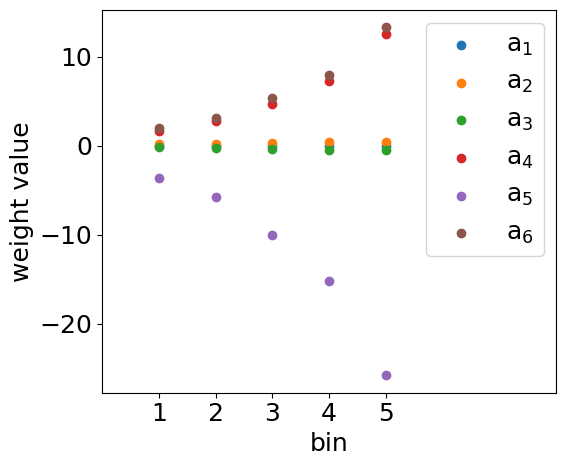

In [5]:
print(all_solutions)
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 18})

weight = []

letters=["a", "b", "c", "d", "e", "f"]
for letter in all_solutions[1].keys():
    weight = []
    for bin in all_solutions.keys():
        weight += [all_solutions[bin][letter]]

    plt.scatter(bins,weight,label=letter)

plt.ylabel("weight value")
ax=plt.gca()
ax.set_xticks(bins)
# ax.set_ylim([-50,20])
ax.set_xlim([0,8])
labels=[fr"a$_{i}$" for i in [1,2,3,4,5,6]]
plt.legend(labels,loc="upper right")
plt.xlabel("bin")
# plt.xticks(ticks=labels=["a", "b", "c", "d", "e", "f"])
plt.tight_layout()
plt.savefig(f"/lustre/fs22/group/atlas/freder/hh/run/plots/linear_combine_bin_solutions_{variable}.pdf")



In [6]:
for k2v in np.arange(0,2,0.1):
    print(k2v)
    for i in bins:
        print(xsec_solved(k2v, 1, 1, all_solutions[i]))
        

0.0
1.80679050171466
2.90554487128633
5.00503867506978
7.54307799974245
12.8799219682502
0.1
1.47563153745965
2.37072933726698
4.08112005187720
6.13644217180618
10.4625543164313
0.2
1.17824405163746
1.89051361848783
3.25158934957047
4.87508000299412
8.29642965885553
0.30000000000000004
0.914628044248063
1.46489771494886
2.51644656814960
3.75899149330625
6.38154799552289
0.4
0.684783515291477
1.09388162665007
1.87569170761457
2.78817664274259
4.71790932643339
0.5
0.488710464767696
0.777465353591477
1.32932476796540
1.96263545130312
3.30551365158702
0.6000000000000001
0.326408892676721
0.515648895773065
0.877345749202079
1.28236791898786
2.14436097098380
0.7000000000000001
0.197878799018552
0.308432253194839
0.519754651324611
0.747374045796794
1.23445128462371
0.8
0.103120183793190
0.155815425856799
0.256551474332994
0.357653831729930
0.575784592506757
0.9
0.0421330470006334
0.0577984137589440
0.0877362182272305
0.113207276787264
0.168360894632942
1.0
0.0149173886408827
0.014381216901275

In [7]:
# solutions for the hists used to extract the weights
for i in bins:
    print(i)
    print(xsec_solved(1, 1, 1,all_solutions[i]))
    print(xsec_solved(1.5, 1, 1,all_solutions[i]))
    print(xsec_solved(1, 1, 2,all_solutions[i]))
    print(xsec_solved(1, 1, 10,all_solutions[i]))
    print(xsec_solved(1, 0.5, 1,all_solutions[i]))
    print(xsec_solved(1, 0.5, -5,all_solutions[i]))

1
0.0149173886408827
0.385411273334219
0.0132869169186591
0.314239388344504
0.957476149733033
0.680379921193578
2
0.0143812169012758
0.616292461215721
0.00919279187191790
0.530614045261046
1.53966280551651
1.20379592927272
3
0.0133088830073165
1.05699102019553
0.00896953493920449
0.721160928135042
2.66155619556172
2.06161887710218
4
0.0140343809687993
1.69727478873947
0.00840001479426888
0.873420500172593
4.10994591604920
3.33820093911088
5
0.0121801910022672
2.99992158649596
0.00553287026741422
0.852888909575935
7.08322567164100
6.30376742264919
